# Asset Portfolio Management using Deep Reinforcement Learning
---

## 7 Backtesting and Evaluation of the Portfolios without transaction costs

### 7.1 Import Relevant Packages

In [3]:
import numpy as np 
import pandas as pd 
import pyfolio as pf
from pyfolio import timeseries
import matplotlib.pylab as plt
#from backtest import BackTestStats, BaselineStats, BackTestPlot, backtest_strat, baseline_strat

F:\Anaconda\envs\py310_env\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 7.2 Load the Train and Test Data for Portfolios

In [6]:
max_sharpe_portfolio=pd.read_csv('./datasets/max_sharpe.csv')
uniform_weights_port=pd.read_csv('./datasets/equal_weights.csv')

prices_train_df = pd.read_csv('./datasets/train_close.csv')
prices_test_df = pd.read_csv('./datasets/test_close.csv')

a2c_train_daily_return= pd.read_csv('./datasets/a2c_train_daily_return.csv')

a2c_test_daily_return= pd.read_csv('./datasets/a2c_test_daily_return.csv')

a2c_test_weights= pd.read_csv('./weights/a2c_test_weights.csv')

In [84]:
max_sharpe_portfolio

,BOREO,ELISA,ICP1V,MEKKO,NDA-FI,NESTE,OLVAS,SAMPO,UPM,YIT
0,0.176,0.19764,0.35241,0.07268,0.0,0.20127,0.0,0.0,0.0,0.0


In [7]:
prices_train_df['date'] = pd.to_datetime(prices_train_df['date'])

In [8]:
prices_train_df.set_index('date', inplace=True)
#prices_train_df.head()

In [9]:
prices_test_df['date'] = pd.to_datetime(prices_test_df['date'])

In [11]:
prices_test_df.set_index('date', inplace=True)
#prices_test_df.head()

In [18]:
prices_train_df = prices_train_df.apply(pd.to_numeric, errors='coerce')
prices_test_df = prices_test_df.apply(pd.to_numeric, errors='coerce')
returns_train = prices_train_df.pct_change() # get the assets daily returns
returns_test = prices_test_df.pct_change()

### 7.4 Evaluating the Portfolios on Test Data

In [21]:
uw_weights = uniform_weights_port.values.flatten()
uw_test_returns = returns_test.dot(uw_weights)
uw_test_returns=uw_test_returns.fillna(0)
uw_test_cum_returns = (1+uw_test_returns).cumprod()
uw_test_cum_returns.name = "Equal weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_test_returns = returns_test.dot(max_sharpe_weights)
max_sharpe_test_returns=max_sharpe_test_returns.fillna(0)
max_sharpe_test_cum_returns = (1+max_sharpe_test_returns).cumprod()
max_sharpe_test_cum_returns.name = "Max Sharpe"

a2c_test_cum_returns = (1 + a2c_test_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
a2c_test_cum_returns = a2c_test_cum_returns['daily_return']
a2c_test_cum_returns.name = 'A2C'
a2c_test_cum_returns.index = pd.to_datetime(a2c_test_cum_returns.index)

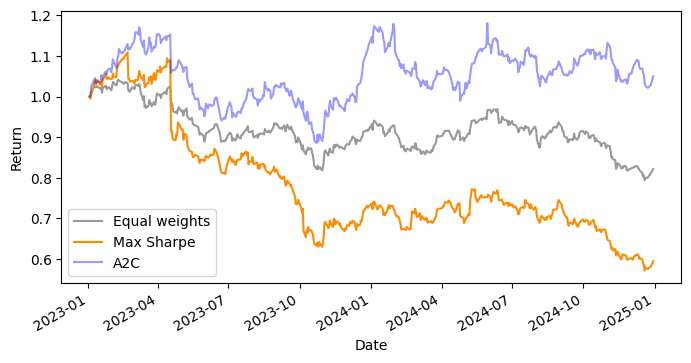

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
uw_test_cum_returns.plot(ax=ax, color="black", alpha=.4);
max_sharpe_test_cum_returns.plot(ax=ax, color="darkorange");
a2c_test_cum_returns.plot(ax=ax, color='blue', alpha=.4)
plt.legend(loc="best");
#plt.grid(True);
plt.xlabel('Date')
ax.set_ylabel("Return");
fig.savefig('results/back_test_on_test_data.png');

### 7.5 Get the Portfolio Statistics

In [26]:
uw_test_returns_df = pd.DataFrame({
    'date': uw_test_returns.index, 
    'daily_return': uw_test_returns.values
}).reset_index(drop=True)

In [28]:
uw_test_returns = pd.DataFrame({
    'date': uw_test_returns.index, 
    'daily_return': uw_test_returns.values
}).reset_index(drop=True)

max_sharpe_test_returns = pd.DataFrame({
    'date': max_sharpe_test_returns.index, 
    'daily_return': max_sharpe_test_returns.values
}).reset_index(drop=True)

a2c_test_daily_return['date'] = pd.to_datetime(a2c_test_daily_return['date'])

In [30]:
#Calculations
def calculate_annual_return(returns):
    cumulative_return = np.prod(1 + returns) - 1  # Cumulative return for the entire period
    num_years = len(returns) / 252  # Assume 252 trading days per year
    annual_return = (1 + cumulative_return) ** (1 / num_years) - 1  # Annualized return
    return annual_return
def calculate_cumulative_return(returns):
    cumulative_return = np.prod(1 + returns) - 1
    return cumulative_return
def calculate_sharpe_ratio_entire_period(returns, risk_free_rate=0.0):
    mean_return = np.mean(returns)*252
    volatility = np.std(returns)*np.sqrt(252)
    sharpe_ratio = (mean_return - risk_free_rate) / volatility
    return sharpe_ratio
def calculate_max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    return max_drawdown
def calculate_annual_volatility(returns):
    daily_volatility = np.std(returns)  # Daily standard deviation
    annual_volatility = daily_volatility * np.sqrt(252)  # Annualize volatility
    return annual_volatility
def calculate_calmar_ratio(annual_return, max_drawdown):
    if max_drawdown == 0:  # Prevent division by zero
        return np.nan
    return annual_return / abs(max_drawdown)
def calculate_skewness(returns):
    return returns.skew()
def calculate_kurtosis(returns):
    return returns.kurt()

In [32]:
uw_test_returns_mod = uw_test_returns['daily_return']
max_sharpe_test_returns_mod = max_sharpe_test_returns['daily_return']
a2c_test_daily_return_mod = a2c_test_daily_return['daily_return']

for portfolio_name, returns in {
    "Uniform Weights": uw_test_returns_mod,
    "Maximum Sharpe": max_sharpe_test_returns_mod,
    "A2C Model": a2c_test_daily_return_mod,
}.items():
    try:
        sharpe_ratio = calculate_sharpe_ratio_entire_period(returns)
        annual_return = calculate_annual_return(returns)
        max_drawdown = calculate_max_drawdown(returns)
        cumulative_return = calculate_cumulative_return(returns)
        annual_volatility = calculate_annual_volatility(returns)
        calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
        skewness = calculate_skewness(returns)
        kurt = calculate_kurtosis(returns)
        
        # Print results
        print(f"{portfolio_name} Portfolio:")
        print(f"  Annual Return: {annual_return:.6f}")
        print(f"  Cumulative Return: {cumulative_return:.6f}")
        print(f"  Annualized Sharpe Ratio: {sharpe_ratio:.6f}")
        print(f"  Maximum Drawdown: {max_drawdown:.6f}")
        print(f"  Annual Volatility: {annual_volatility:.6f}")
        print(f"  Calmar Ratio: {calmar_ratio:.6f}")
        print(f"  Skewness: {skewness:.6f}")
        print(f"  Kurtosis: {kurt:.6f}")
        print("-" * 50)
    except Exception as e:
        print(f"Error in {portfolio_name} Portfolio: {e}")

Uniform Weights Portfolio:
  Annual Return: -0.096556
  Cumulative Return: -0.178178
  Annualized Sharpe Ratio: -0.679575
  Maximum Drawdown: -0.237504
  Annual Volatility: 0.135785
  Calmar Ratio: -0.406543
  Skewness: -0.391634
  Kurtosis: 1.489601
--------------------------------------------------
Maximum Sharpe Portfolio:
  Annual Return: -0.235843
  Cumulative Return: -0.405372
  Annualized Sharpe Ratio: -1.042950
  Maximum Drawdown: -0.484098
  Annual Volatility: 0.231289
  Calmar Ratio: -0.487181
  Skewness: -2.845867
  Kurtosis: 30.403789
--------------------------------------------------
A2C Model Portfolio:
  Annual Return: 0.025561
  Cumulative Return: 0.049986
  Annualized Sharpe Ratio: 0.227196
  Maximum Drawdown: -0.243522
  Annual Volatility: 0.197544
  Calmar Ratio: 0.104963
  Skewness: -0.749896
  Kurtosis: 4.617901
--------------------------------------------------


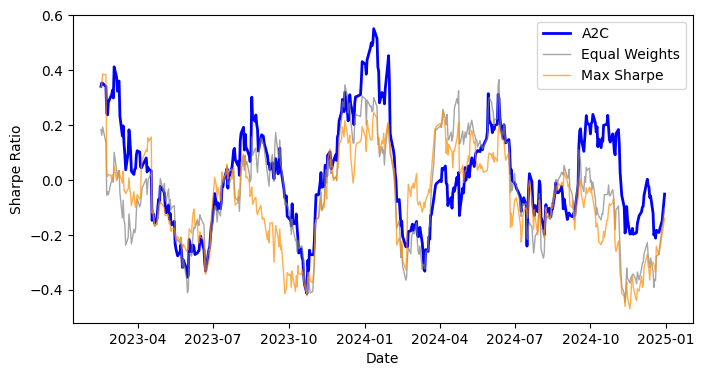

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

rolling_window = 30  # 30-day rolling window
risk_free_rate = 0  # Assuming a risk-free rate of 0

a2c_test_daily_return['rolling_sharpe'] = (
    a2c_test_daily_return['daily_return'].rolling(rolling_window).mean() - risk_free_rate
) / a2c_test_daily_return['daily_return'].rolling(rolling_window).std()

uw_test_returns['rolling_sharpe'] = (
    uw_test_returns['daily_return'].rolling(rolling_window).mean() - risk_free_rate
) / uw_test_returns['daily_return'].rolling(rolling_window).std()

max_sharpe_test_returns['rolling_sharpe'] = (
    max_sharpe_test_returns['daily_return'].rolling(rolling_window).mean() - risk_free_rate
) / max_sharpe_test_returns['daily_return'].rolling(rolling_window).std()

plt.figure(figsize=(8, 4))

plt.plot(
    a2c_test_daily_return['date'], 
    a2c_test_daily_return['rolling_sharpe'], 
    label='A2C', 
    linewidth=2, 
    color='blue'
)

plt.plot(
    uw_test_returns['date'], 
    uw_test_returns['rolling_sharpe'], 
    label='Equal Weights', 
    linewidth=1, 
    color='gray', 
    alpha=0.7
)

plt.plot(
    max_sharpe_test_returns['date'], 
    max_sharpe_test_returns['rolling_sharpe'], 
    label='Max Sharpe', 
    linewidth=1, 
    color='darkorange', 
    alpha=0.7
)

plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
#plt.grid()

plt.savefig('results/rolling_sharpe_ratio.png', bbox_inches='tight')

plt.show()

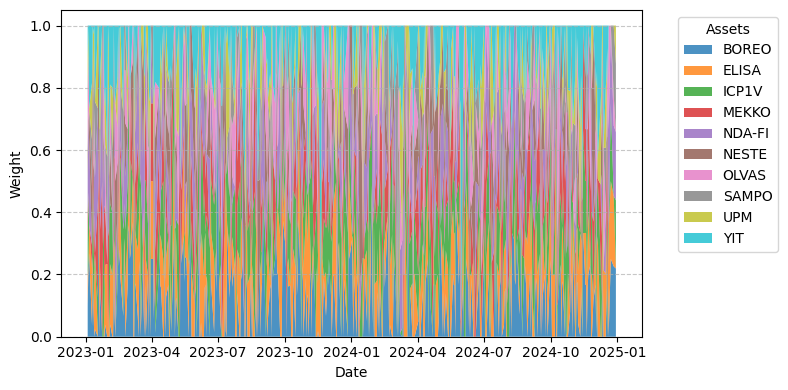

In [35]:
a2c_test_weights['date'] = pd.to_datetime(a2c_test_weights['date'])

a2c_test_weights.set_index('date', inplace=True)

plt.figure(figsize=(8, 4))
plt.stackplot(
    a2c_test_weights.index,  # Dates for x-axis
    a2c_test_weights.T,  # Transposed weights for stackplot
    labels=a2c_test_weights.columns,  # Asset names for legend
    alpha=0.8
)
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig('results/test_weights.png', bbox_inches='tight')
plt.show()

In [37]:
a2c_test_weights

,BOREO,ELISA,ICP1V,MEKKO,NDA-FI,NESTE,OLVAS,SAMPO,UPM,YIT
date,,,,,,,,,,
2023-01-03,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2023-01-04,0.230318,0.000000,0.230318,0.002210,0.230318,0.000000,0.230318,0.000000,0.076519,0.000000
2023-01-05,0.267989,0.091622,0.000000,0.000000,0.267989,0.104412,0.000000,0.000000,0.000000,0.267989
2023-01-09,0.036414,0.183312,0.000000,0.074548,0.000000,0.183312,0.000000,0.155788,0.183312,0.183312
2023-01-10,0.256263,0.000000,0.236219,0.256263,0.000000,0.242695,0.008560,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-12-19,0.200000,0.000000,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000
2024-12-20,0.000000,0.334561,0.000000,0.000000,0.330877,0.000000,0.334561,0.000000,0.000000,0.000000
2024-12-23,0.250000,0.250000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000


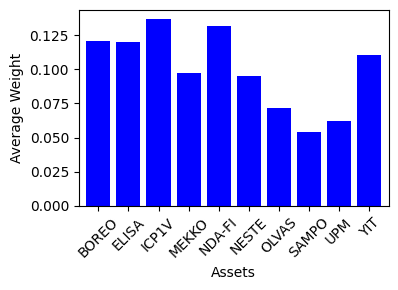

In [38]:
average_weights =a2c_test_weights.mean()

average_weights_df = average_weights.reset_index()
average_weights_df.columns = ['Asset', 'Average Weight']
plt.figure(figsize=(4, 3))
average_weights.plot(kind='bar', color='blue', width=0.8)

plt.xlabel('Assets')
plt.ylabel('Average Weight')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.savefig('results/average_weights.png', bbox_inches='tight')
plt.show()

In [43]:
import numpy as np
import pandas as pd


trading_days = 252  # Number of trading days in a year
risk_free_rate = 0  # Risk-free rate

financial_metrics = pd.DataFrame()

cumulative_return = (1 + returns_test).cumprod().iloc[-1] - 1
financial_metrics['Cumulative Return (Rc)'] = cumulative_return

daily_volatility = returns_test.std()
annual_volatility = daily_volatility * np.sqrt(trading_days)
financial_metrics['Annual Volatility (σa)'] = annual_volatility

mean_annualized_return = returns_test.mean() * trading_days

sharpe_ratio = mean_annualized_return / annual_volatility
financial_metrics['Sharpe Ratio (S)'] = sharpe_ratio

cumulative_returns = (1 + returns_test).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = cumulative_returns / rolling_max - 1
max_drawdown = drawdown.min()
financial_metrics['Maximum Drawdown (MDD)'] = max_drawdown

calmar_ratio = mean_annualized_return / abs(max_drawdown)
financial_metrics['Calmar Ratio (Cr)'] = calmar_ratio

skewness = returns_test.skew()
financial_metrics['Skewness (Sk)'] = skewness

kurtosis = returns_test.kurtosis()
financial_metrics['Kurtosis (K)'] = kurtosis

financial_metrics.T

,BOREO,ELISA,ICP1V,MEKKO,NDA-FI,NESTE,OLVAS,SAMPO,UPM,YIT
Cumulative Return (Rc),-0.707762,-0.086292,-0.408092,0.458780,0.208790,-0.704916,-0.019845,-0.094465,-0.163596,0.013972
Annual Volatility (σa),0.339718,0.162060,0.528526,0.338795,0.208904,0.377381,0.200718,0.167712,0.233642,0.379260
Sharpe Ratio (S),-1.703977,-0.207285,-0.209176,0.744362,0.575382,-1.482001,0.048277,-0.222879,-0.278742,0.205842
Maximum Drawdown (MDD),-0.747883,-0.300071,-0.728276,-0.295880,-0.178904,-0.747669,-0.184915,-0.217173,-0.285038,-0.416395
Calmar Ratio (Cr),-0.774014,-0.111949,-0.151804,0.852324,0.671864,-0.748031,0.052403,-0.172118,-0.228481,0.187484
Skewness (Sk),-0.468958,-0.948269,-4.771896,1.309230,-0.431411,-1.162387,0.149511,-0.268781,-0.811562,0.971997
Kurtosis (K),4.110150,5.654871,59.884438,11.448099,3.521880,8.931207,1.808764,3.158403,5.869398,9.637207


In [45]:
returns_test

,BOREO,ELISA,ICP1V,MEKKO,NDA-FI,NESTE,OLVAS,SAMPO,UPM,YIT
date,,,,,,,,,,
2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,0.002632,-0.013573,-0.003468,0.016911,0.019317,-0.013817,-0.006079,0.011635,-0.017969,-0.008283
2023-01-05,0.047244,0.011129,-0.008121,-0.006652,0.017994,0.013551,0.016820,-0.016747,0.012779,0.013667
2023-01-09,-0.022556,0.019412,0.057310,0.026786,0.008650,0.017902,0.022557,0.007182,0.004875,0.024719
2023-01-10,0.025641,0.005889,0.022124,-0.013043,-0.002051,-0.012244,-0.016177,-0.006112,-0.007135,-0.014620
...,...,...,...,...,...,...,...,...,...,...
2024-12-19,-0.029126,-0.010029,-0.021339,-0.027027,-0.014131,-0.018844,-0.008576,-0.004106,-0.002328,-0.005882
2024-12-20,0.040000,0.002412,0.015857,0.031250,-0.021022,-0.020079,-0.001730,0.005153,-0.001945,0.007608
2024-12-23,-0.014423,-0.003850,-0.004878,0.018519,0.005369,-0.006236,0.005199,-0.000513,0.002338,0.024329


In [52]:
cumulative_returns

,BOREO,ELISA,ICP1V,MEKKO,NDA-FI,NESTE,OLVAS,SAMPO,UPM,YIT
date,,,,,,,,,,
2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,1.002632,0.986427,0.996532,1.016911,1.019317,0.986183,0.993921,1.011635,0.982031,0.991717
2023-01-05,1.050000,0.997405,0.988439,1.010147,1.037658,0.999547,1.010638,0.994693,0.994581,1.005271
2023-01-09,1.026316,1.016767,1.045087,1.037204,1.046634,1.017440,1.033435,1.001837,0.999430,1.030121
2023-01-10,1.052631,1.022755,1.068208,1.023675,1.044488,1.004983,1.016717,0.995713,0.992299,1.015060
...,...,...,...,...,...,...,...,...,...,...
2024-12-19,0.266884,0.906276,0.583237,1.386563,1.204761,0.278778,0.970085,0.892428,0.809636,0.963477
2024-12-20,0.277559,0.908462,0.592486,1.429893,1.179434,0.273181,0.968407,0.897026,0.808062,0.970807
2024-12-23,0.273556,0.904964,0.589595,1.456373,1.185766,0.271477,0.973442,0.896567,0.809951,0.994425


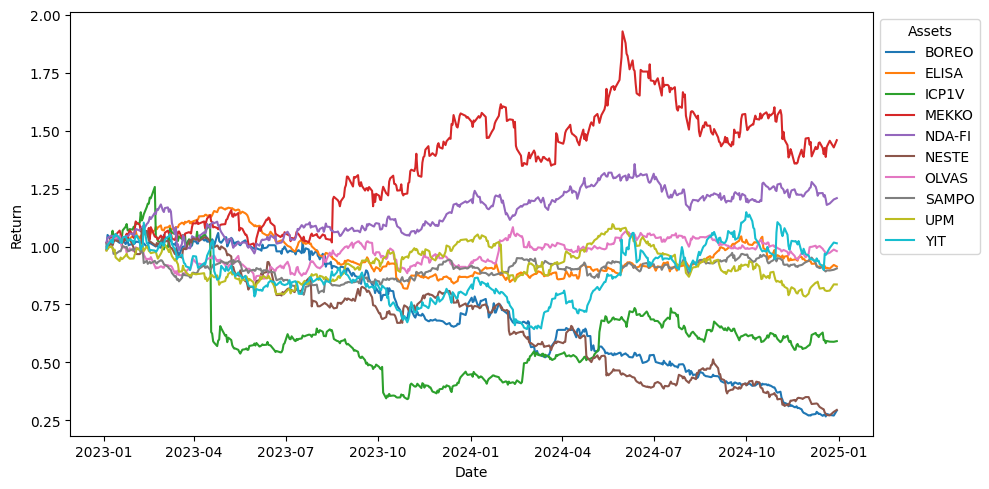

In [68]:
plt.figure(figsize=(10, 5))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.xlabel('Date')
plt.ylabel('Return')
plt.legend(title='Assets', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.savefig('results/cumulative_returns_stocks.png', bbox_inches='tight')
plt.show()

In [70]:
returns_train

,BOREO,ELISA,ICP1V,MEKKO,NDA-FI,NESTE,OLVAS,SAMPO,UPM,YIT
date,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.020997,-0.012346,-0.074627,-0.010811,-0.022881,-0.004998,0.023866,-0.010981,-0.018882,-0.029091
2015-01-07,-0.007712,0.023214,0.064517,0.021858,-0.014369,0.034656,-0.020979,-0.011619,0.006662,0.000936
2015-01-08,0.000000,-0.003927,-0.090911,0.026738,0.011879,0.010194,-0.002381,0.021682,0.016176,0.051918
2015-01-09,0.010363,0.001314,0.000000,0.005208,-0.018143,-0.023546,0.007637,-0.002813,-0.000724,-0.005780
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.002632,0.003017,-0.008235,-0.006865,-0.001390,-0.000910,-0.001577,0.009746,-0.005301,0.020101
2022-12-27,-0.002639,-0.002807,0.029656,0.013825,0.006167,-0.004557,0.001580,-0.004625,-0.000280,-0.007389
2022-12-28,-0.023809,-0.002815,-0.017281,-0.004546,-0.006129,-0.008240,0.007886,-0.004242,-0.003367,-0.004963


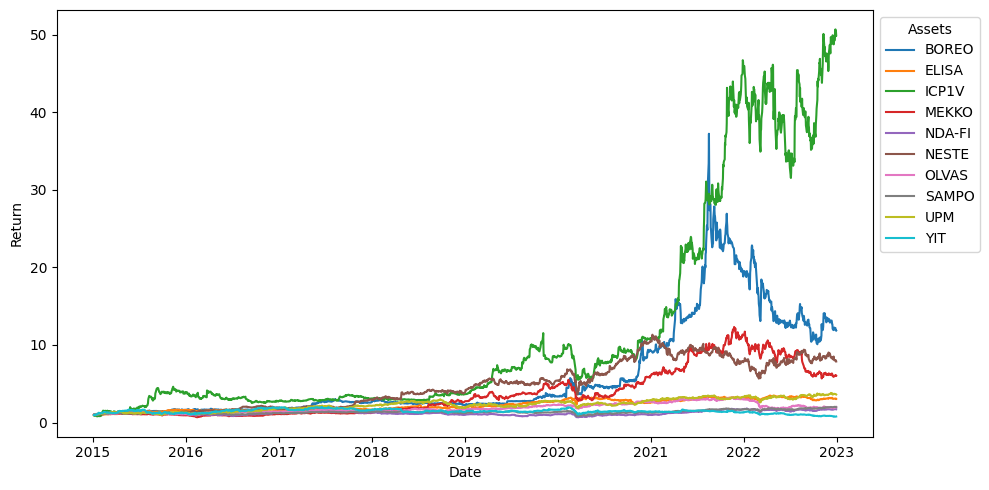

In [78]:
returns_train = pd.DataFrame(returns_train)

cumulative_returns_train = (1 + returns_train).cumprod()

plt.figure(figsize=(10, 5))
for column in cumulative_returns_train.columns:
    plt.plot(cumulative_returns_train.index, cumulative_returns_train[column], label=column)

plt.xlabel('Date')
plt.ylabel('Return')
plt.legend(title='Assets', bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.tight_layout()

plt.savefig('results/cumulative_returns_train.png', bbox_inches='tight')
plt.show()